# Modeling Exotic Option Prices with Monte Carlo

**Brendan Reid, Calvin Combs, Dalton Fowler, Xander Struntz**

## Introduction

In [1]:
!pip install numpy
!pip install matplotlib

     |████████████████████████████████| 15.3 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 26.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 30.0 MB/s eta 0:00:01


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# generates matrix of stock paths.
# rows represent path of a stock at each time step.
# each stock starts from the same price.

# parameters:
# S0: initial stock price
# mu: expected return of stock
# sig: standard deviation of stock price
# dt: size of time step (annual; give 1/365 for daily)
# steps: number of time steps to generate
# numPaths: number of stock paths to generate
def assetPaths(S0,mu,sig,dt,steps,numPaths):
    drift = mu - sig*sig/2
    
    cProd = np.cumprod(np.exp(drift*dt+sig*np.sqrt(dt)*np.random.normal(0, 1, (steps,numPaths))), axis=0)

    # build array
    S = S0 * (np.vstack((np.ones((1,numPaths)), (cProd))))
    
    return S.T

We give some examples of calling `assetPaths()`. (This is for personal reference, we might want to delete these when we submit this project).

In [4]:
# Each row is a path
paths = assetPaths(100, .15, .3, 1/4, 5, 3)
pathOne = paths[0]
print(pathOne)

[100.         100.53401443 116.40025865 121.064085   134.31545674
 134.00171146]


In [5]:
# Note: the asset paths are stored in rows, not the columns, of the matrix.
# Thus the first column is the initial price of each asset
print(paths.T[0])

[100. 100. 100.]


In [6]:
# A different path:
pathTwo = paths[1]
print(pathTwo)

[100.         107.75838879  83.01054085  85.20894427  98.23070996
  99.27201759]


In [7]:
# compute a discrete integral

# parameters:
# arr: an array. Must only contain numeric types.
def discreteIntegral(arr):
    result = 0
        
    for i in range(0, len(arr)):
        result += arr[i] * (1 / len(arr))
        
    return result

In [8]:
# We give some examples of calling discreteIntegral

# we expect 1/3 (1 + 2 + 3) = 2
print(discreteIntegral([1, 2, 3]))

paths = assetPaths(100, .8, .9, 1/12, 10, 5)[0]
print(discreteIntegral(paths))

2.0
277.13815852414206


## Parisian Indicator Functions

In [9]:
# Parisian Knock In/Out Down indicator
# Returns true if the down Parisian continuity requirement is satisfied

def downParisCont(path, barrier):
    result = True
    
    for i in range(len(path) + 1):
        for j in range(i + 1, len(path)):
            for k in range(i, j + 1):
                if path[k] > barrier:
                    result = False
                    break
                    
            if result == True:
                return True
                
            result = True # otherwise once set to false, it will always be false; bad
            
    return False
                
def upParisCont(path, barrier):
    result = True
    
    for i in range(len(path) + 1):
        for j in range(i + 1, len(path)):
            for k in range(i, j + 1):
                if path[k] < barrier:
                    result = False
                    break
                    
            if result == True:
                return True
                
            result = True # otherwise once set to false, it will always be false; bad
            
    return False

In [10]:
# Simple functions to find the max and min of a array.
# We will be using these to help plot our outputs.

# NOTE: I thought I needed this for plotting but it appears not
# leaving incase we need at another time.
def getMax(arr):
    max = arr[0]
    for x in arr[1:]:
        if x > max:
            max = x
    return max

def getMin(arr):
    min = arr[0]
    for x in arr[1:]:
        if x < min:
            min = x
    return min

In [11]:
# Here we test the functions by a very straightforward test
print(getMax(pathOne), getMin(pathOne), sep="|")
print(getMax(pathTwo), getMin(pathTwo), sep="|")

134.31545673811013|100.0
107.75838879053825|83.01054085359051


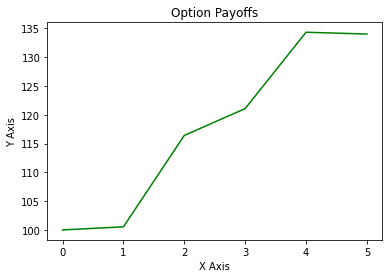

In [12]:
# Plot the first asset path
plt.title("Option Payoffs")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
x = np.arange(0, len(pathOne))
y = np.array(pathOne)
plt.plot(x, y, color = "green")
plt.show()

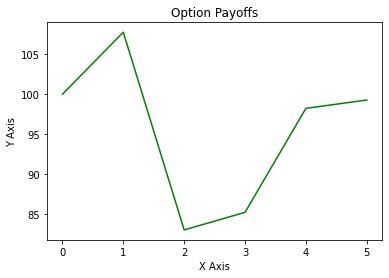

In [13]:
# Plot the second asset path
plt.title("Option Payoffs")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
x = np.arange(0, len(pathTwo))
y = np.array(pathTwo)
plt.plot(x, y, color = "green")
plt.show()

# Option Payoff Functions

In [14]:
# All functions have one or more of these parameters

# path: path taken by the asset
# K: strike price

## Asian:

In [15]:
# Compute the payoff of an asian average price call option

# parameters:
# path: path taken by the asset
# K: strike price
def asianAvgPriceCall(path, K):
    avgPrice = discreteIntegral(path)
    intrinsic = avgPrice - K
    
    return intrinsic if intrinsic > 0 else 0

In [16]:
def asianAvgPricePut(path, K):
    avgPrice = discreteIntegral(path)
    intrinsic = K - avgPrice
    
    return intrinsic if intrinsic > 0 else 0

In [17]:
def asianAvgStrikeCall(path):
    avgPrice = discreteIntegral(path)
    S_T = path[len(path) - 1]
    intrinsic = S_T - avgPrice
    
    return intrinsic if intrinsic > 0 else 0

In [18]:
def asianAvgStrikePut(path):
    avgPrice = discreteIntegral(path)
    S_T = path[len(path) - 1]
    intrinsic = avgPrice - S_T
    
    return intrinsic if intrinsic > 0 else 0

## Lookback:

In [19]:
def lookbackFixedCall(path, K):
    Smax = getMax(path)
    intrinsic = Smax - K
    
    return intrinsic if intrinsic > 0 else 0

In [20]:
def lookbackFixedPut(path, K):
    Smin = getMin(path)
    intrinsic = K - Smin
    
    return intrinsic if intrinsic > 0 else 0

In [21]:
def lookbackFloatingCall(path):
    S_T = path[len(path) - 1]
    Smin = getMin(path)
    
    intrinsic = S_T - Smin
        
    return intrinsic if intrinsic > 0 else 0

In [22]:
def lookbackFloatingPut(path):
    S_T = path[len(path) - 1]
    Smax = getMax(path)
    
    intrinsic = Smax - S_T
        
    return intrinsic if intrinsic > 0 else 0

In [23]:
# Chooser

def chooser(path, K, choiceTime):
    S_T = path[choiceTime]
    
    return S_T - K if S_T - K > 0 else K - S_T

## Knock In

In [24]:
# Note barrier options can use the following parameters.

# parameters:
# rebate: payoff given when the threshold is passed
# B: threshold at which the rebate is returned

In [25]:
def downInCall(path, B, K, rebate):
    if getMin(path) <= B:
        S_T = path[len(path) - 1]
        intrinsic = S_T - K
                
        return intrinsic if intrinsic > 0 else 0
    
    # TODO: what does rebate take?
    return rebate()

def downInPut(path, B, K, rebate):
    if getMin(path) <= B:
        S_T = path[len(path) - 1]
        intrinsic = K - S_T
                
        return intrinsic if intrinsic > 0 else 0
    
    # TODO: what does rebate take?
    return rebate()

In [26]:
def upInCall(path, B, K, rebate):
    if getMax(path) >= B:
        S_T = path[len(path) - 1]
        intrinsic = S_T - K
                
        return intrinsic if intrinsic > 0 else 0
    
    # TODO: what does rebate take?
    return rebate()

def upInPut(path, B, K, rebate):
    if getMax(path) >= B:
        S_T = path[len(path) - 1]
        intrinsic = K - S_T
                
        return intrinsic if intrinsic > 0 else 0
    
    # TODO: what does rebate take?
    return rebate()

## Knock Out

In [27]:
def downOutCall(path, B, K, rebate):
    if getMin(path) <= B:
        return rebate()
    
    S_T = path[len(path) - 1]
    intrinsic = S_T - K
    
    return intrinsic if intrinsic > 0 else 0

def downOutPut(path, B, K, rebate):
    if getMin(path) <= B:
        return rebate()
    
    S_T = path[len(path) - 1]
    intrinsic = K - S_T
    
    return intrinsic if intrinsic > 0 else 0

def upOutCall(path, B, K, rebate):
    if getMax(path) >= B:
        return rebate()
    
    S_T = path[len(path) - 1]
    intrinsic = S_T - K
    
    return intrinsic if intrinsic > 0 else 0

def upOutPut(path, B, K, rebate):
    if getMax(path) >= B:
        return rebate()
    
    S_T = path[len(path) - 1]
    intrinsic = K - S_T
    
    return intrinsic if intrinsic > 0 else 0

## Parisian

In [28]:
def parisDownInCall(path, barrier, K, rebate):
    if (downParisCont(path, barrier) == True):
        S_T = path[len(path) - 1]
        intrinsic = S_T - K
    
        return intrinsic if intrinsic > 0 else 0
    
    return rebate()

def parisDownInPut(path, barrier, K, rebate):
    if (downParisCont(path, barrier) == True):
        S_T = path[len(path) - 1]
        intrinsic = K - S_T
    
        return intrinsic if intrinsic > 0 else 0
    
    return rebate()

def parisUpInCall(path, barrier, K, rebate):
    if (upParisCont(path, barrier) == True):
        S_T = path[len(path) - 1]
        intrinsic = S_T - K
    
        return intrinsic if intrinsic > 0 else 0
    
    return rebate()

def parisUpInPut(path, barrier, K, rebate):
    if (upParisCont(path, barrier) == True):
        S_T = path[len(path) - 1]
        intrinsic = K - S_T
    
        return intrinsic if intrinsic > 0 else 0
    
    return rebate()

# Out

def parisDownOutCall(path, barrier, K, rebate):
    if (downParisCont(path, barrier) == True):
        return rebate()

    S_T = path[len(path) - 1]
    intrinsic = S_T - K
    
    return intrinsic if intrinsic > 0 else 0

def parisDownOutPut(path, barrier, K, rebate):
    if (downParisCont(path, barrier) == True):
        return rebate()
    
    S_T = path[len(path) - 1]
    intrinsic = K - S_T
    
    return intrinsic if intrinsic > 0 else 0
    
def parisUpOutCall(path, barrier, K, rebate):
    if (upParisCont(path, barrier) == True):
        return rebate()

    S_T = path[len(path) - 1]
    intrinsic = S_T - K
    
    return intrinsic if intrinsic > 0 else 0

def parisUpOutPut(path, barrier, K, rebate):
    if (upParisCont(path, barrier) == True):
        return rebate()
    
    S_T = path[len(path) - 1]
    intrinsic = K - S_T
    
    return intrinsic if intrinsic > 0 else 0

# Pricing

In [29]:
# This applies to all non-chooser options

# parameters:
# path: path taken by the asset. One dimensional numeric array
# r: risk free rate
# payoff: the correct payoff function, like parisUpOutCall or asianAvgPriceCall
def priceNonChooser(path, r, payoff):
    T = len(path)
    
    return exp(-r*T)*payoff(path)

## TODO: non-chooser pricing

# Tests

## Util: Parisian Continuity checkers

In [30]:
# Down

path = [100, 110, 100, 200]

if (downParisCont(path, 90) != False):
    print("Test failed! down parisian continuity failed")

path = [100, 80, 90, 200]

if (downParisCont(path, 90) != True):
    print("Test failed! down parisian continuity failed 2")
    
path = [80, 80, 90, 60]

if (downParisCont(path, 90) != True):
    print("Test failed! down parisian continuity failed 3")
    
path = [100, 100, 90, 100]

if (downParisCont(path, 90) != False):
    print("Test failed! down parisian continuity failed 4")

In [31]:
# Up

path = [100, 110, 100, 200]

if (upParisCont(path, 300) != False):
    print("Test failed! down parisian continuity failed")

path = [50, 80, 90, 20]

if (upParisCont(path, 80) != True):
    print("Test failed! down parisian continuity failed 2")
    
path = [80, 80, 90, 60]

if (upParisCont(path, 80) != True):
    print("Test failed! down parisian continuity failed 3")
    
path = [80, 80, 90, 80]

if (upParisCont(path, 90) != False):
    print("Test failed! down parisian continuity failed 4")

## Asian:

In [32]:
# Asian average price call positive

path = [100, 100, 100, 100]
strike = 75

if (asianAvgPriceCall(path, strike) != 25):
    print("Test failed! Asian Average Price Call Option produced wrong payoff")
    
# Asian average price call zero

path = [100, 57, 88, 120]
strike = 150

if (asianAvgPriceCall(path, strike) != 0):
    print("Test failed! Asian Average Price Call Option produced wrong payoff")

In [33]:
#Asian average strike call positive

path = [50, 0, 40, 100]

if (asianAvgStrikeCall(path) != 100 - 47.5):
    print("Test failed! Asian Average Strike Call Option produced wrong payoff")
    
#Asian average strike call zero

path = [50000, 0, 40, 100]

if (asianAvgStrikeCall(path) != 0):
    print("Test failed! Asian Average Strike Call Option produced wrong payoff")

In [34]:
#Asian average strike put positive

path = [50, 0, 0, 40, 10]

if (asianAvgStrikePut(path) != 20 - 10):
    print("Test failed! Asian Average Strike Put Option produced wrong payoff")
    
#Asian average strike put zero

path = [0, 0, 40, 100]

if (asianAvgStrikePut(path) != 0):
    print("Test failed! Asian Average Strike Put Option produced wrong payoff")

## Lookback:

In [35]:
# Lookback fixed call positive

path = [50, 0, 100, 99]

if (lookbackFixedCall(path, 75) != 25):
    print("Test failed! Lookback fixed call produced wrong payoff")

# Lookback fixed call zero

path = [50, 0, 50, 45]

if (lookbackFixedCall(path, 75) != 0):
    print("Test failed! lookback fixed call produced wrong payoff")

In [36]:
# Lookback fixed put positive

path = [50, 0, 100, 99]

if (lookbackFixedPut(path, 75) != 75):
    print("Test failed! Lookback fixed call produced wrong payoff")

# Lookback fixed put zero

path = [500, 1000, 500, 450]

if (lookbackFixedPut(path, 75) != 0):
    print("Test failed! lookback fixed call produced wrong payoff")

In [37]:
# Lookback float call positive

path = [50, 30, 100, 101]

if (lookbackFloatingCall(path) != 71):
    print("Test failed! Lookback float call produced wrong payoff 1")

# Lookback fixed call zero

path = [50, 70, 50, 20]

if (lookbackFloatingCall(path) != 0):
    print("Test failed! lookback float call produced wrong payoff 2")

In [38]:
# Lookback float put positive

path = [50, 0, 100, 99]

if (lookbackFloatingPut(path) != 1):
    print("Test failed! Lookback float call produced wrong payoff 1")

# Lookback float put zero

path = [50, 0, 50, 60]

if (lookbackFloatingPut(path) != 0):
    print("Test failed! lookback float call produced wrong payoff 2")

## Chooser

In [39]:
# Chooser Put

path = [50, 0, 70, 140]
choiceTime = 2
K = 100

if (chooser(path, K, choiceTime) != 100-70):
    print("Test failed! Lookback float call produced wrong payoff 1")

# Lookback float put zero

choiceTime = 3

if (chooser(path, K, choiceTime) != 140-100):
    print("Test failed! lookback float call produced wrong payoff 2")

In [40]:
# This rebate is used in all tests

def rebate():
    return 123

## Knock In

In [41]:
# Down In non-rebate

path = [50, 0, 100, 70]

if (downInCall(path, 60, 40, rebate) != 70-40):
    print("Test failed! down and in call produced wrong payoff 1")

# Down in rebate

path = [50, 30, 50, 60]

if (downInCall(path, 20, 40, rebate) != rebate()):
    print("Test failed! down and in call produced wrong payoff 2")

In [42]:
# Down In non-rebate

path = [50, 0, 100, 20]

if (downInPut(path, 60, 40, rebate) != 40-20):
    print("Test failed! down and in put produced wrong payoff 1")

# Down in rebate

path = [50, 30, 50, 60]

if (downInPut(path, 20, 40, rebate) != rebate()):
    print("Test failed! down and in put produced wrong payoff 2")

In [43]:
# Up In non-rebate

path = [50, 0, 100, 70]

if (upInCall(path, 60, 40, rebate) != 70-40):
    print("Test failed! up and in call produced wrong payoff 1")

# Up in rebate

path = [50, 30, 50, 60]

if (upInCall(path, 90, 40, rebate) != rebate()):
    print("Test failed! up and in call produced wrong payoff 2")

In [44]:
# Up In non-rebate

path = [50, 0, 100, 20]

if (upInPut(path, 60, 40, rebate) != 40-20):
    print("Test failed! up and in call produced wrong payoff 1")

# Up in rebate

path = [50, 30, 50, 60]

if (upInPut(path, 90, 40, rebate) != rebate()):
    print("Test failed! up and in call produced wrong payoff 2")

## Knock Out

In [45]:
# Down out non-rebate

path = [70, 70, 100, 80]

if (downOutCall(path, 60, 40, rebate) != 80-40):
    print("Test failed! down and out call produced wrong payoff 1")

# Down out rebate

path = [50, 30, 50, 60]

if (downOutCall(path, 40, 40, rebate) != rebate()):
    print("Test failed! down and out call produced wrong payoff 2")

In [46]:
# Down out non-rebate

path = [70, 70, 100, 80]

if (downOutPut(path, 60, 100, rebate) != 100-80):
    print("Test failed! down and out call produced wrong payoff 1")

# Down out rebate

path = [50, 30, 50, 60]

if (downOutPut(path, 40, 40, rebate) != rebate()):
    print("Test failed! down and out call produced wrong payoff 2")

In [47]:
# up out non-rebate

path = [70, 70, 100, 80]

if (upOutCall(path, 110, 40, rebate) != 80-40):
    print("Test failed! up and out call produced wrong payoff 1")

# up out rebate

path = [50, 30, 50, 60]

if (upOutCall(path, 40, 40, rebate) != rebate()):
    print("Test failed! up and out call produced wrong payoff 2")

In [48]:
# up out non-rebate

path = [70, 70, 100, 80]

if (upOutPut(path, 110, 400, rebate) != 400-80):
    print("Test failed! up and out call produced wrong payoff 1")

# up out rebate

path = [50, 30, 50, 60]

if (upOutPut(path, 40, 40, rebate) != rebate()):
    print("Test failed! up and out call produced wrong payoff 2")

## Parisian

### Parisian Down-and-In

In [49]:
# Parisian Down In Call no rebate

path = [200, 100, 70, 80]
K = 100

if (parisDownInCall(path, 90, K, rebate) != 0):
    print("Test failed! Parisian Down and In Call produced wrong payoff 1")

path = [200, 70, 70, 130]
K = 100

if (parisDownInCall(path, 90, K, rebate) != 130-100):
    print("Test failed! Parisian Down and In Call produced wrong payoff 2")
    
# Parisian Down In Call rebate

path = [80, 100, 1, 110]

if (parisDownInCall(path, 90, K, rebate) != rebate()):
    print("Test failed! up and out call produced wrong payoff 3")
    
    
# Parisian Down In Put no rebate

path = [200, 100, 70, 80]
K = 100

if (parisDownInPut(path, 90, K, rebate) != K-80):
    print("Test failed! Parisian Down and In Call produced wrong payoff 1")

path = [200, 70, 70, 130]
K = 100

if (parisDownInPut(path, 90, K, rebate) != 0):
    print("Test failed! Parisian Down and In Call produced wrong payoff 2")
    
# Parisian Down In Call rebate

path = [80, 100, 1, 110]

if (parisDownInPut(path, 90, K, rebate) != rebate()):
    print("Test failed! up and out call produced wrong payoff 3")

### Parisian Up-and-In

In [50]:
# Parisian Up In Call no rebate

path = [200, 100, 70, 80]
K = 100

if (parisUpInCall(path, 90, K, rebate) != 0):
    print("Test failed! Parisian Up and In Call produced wrong payoff 1")

path = [20, 70, 70, 40]
K = 30

if (parisUpInCall(path, 50, K, rebate) != 40-30):
    print("Test failed! Parisian Up and In Call produced wrong payoff 2")
    
# Parisian Up In Call rebate

path = [80, 100, 1, 110]

if (parisUpInCall(path, 90, K, rebate) != rebate()):
    print("Test failed! produced wrong payoff 3")
    
    
# Parisian Up In Put no rebate

path = [200, 100, 70, 80]
K = 100

if (parisUpInPut(path, 90, K, rebate) != K-80):
    print("Test failed! produced wrong payoff 4")

path = [20, 70, 70, 200]
K = 100

if (parisUpInPut(path, 50, K, rebate) != 0):
    print("Test failed! Parisian up and In put produced wrong payoff 5")
    
# Parisian Up In Put rebate

path = [80, 100, 1, 110]

if (parisUpInPut(path, 90, K, rebate) != rebate()):
    print("Test failed! up and out put produced wrong payoff 6")

## Parisian Down-and-Out

In [51]:
# Parisian Down Out Call rebate

path = [200, 67, 80, 300]
K = 100

if (parisDownOutCall(path, 90, K, rebate) != rebate()):
    print("Test failed! produced wrong payoff 1")

# Parisian Down Out Call no rebate

path = [70, 700, 34, 130]
K = 100

if (parisDownOutCall(path, 90, K, rebate) != 130-100):
    print("Test failed! produced wrong payoff 2")
    
path = [80, 100, 1, 110]
K = 130

if (parisDownOutCall(path, 90, K, rebate) != 0):
    print("Test failed! produced wrong payoff 3")
    
# Parisian Down In Put no rebate

path = [200, 100, 120, 80]
K = 100

if (parisDownOutPut(path, 90, K, rebate) != K-80):
    print("Test failed! produced wrong payoff 4")

path = [200, 110, 90, 130]
K = 100

if (parisDownOutPut(path, 90, K, rebate) != 0):
    print("Test failed! produced wrong payoff 5")
    
# Parisian Down Out Put rebate

path = [80, 80, 1, 110]

if (parisDownOutPut(path, 90, K, rebate) != rebate()):
    print("Test failed! produced wrong payoff 6")

### Parisian Up-and-Out

In [52]:
# Parisian Up Out Call rebate

path = [200, 100, 80, 300]
K = 100

if (parisUpOutCall(path, 90, K, rebate) != rebate()):
    print("Test failed! produced wrong payoff 1")

# Parisian Up Out Call no rebate

path = [70, 700, 34, 130]
K = 100

if (parisUpOutCall(path, 90, K, rebate) != 130-100):
    print("Test failed! produced wrong payoff 2")
    
path = [80, 100, 1, 110]
K = 130

if (parisUpOutCall(path, 90, K, rebate) != 0):
    print("Test failed! produced wrong payoff 3")
    
# Parisian Up In Put no rebate

path = [200, 70, 120, 80]
K = 100

if (parisUpOutPut(path, 90, K, rebate) != K-80):
    print("Test failed! produced wrong payoff 4")

path = [80, 90, 80, 130]
K = 100

if (parisUpOutPut(path, 90, K, rebate) != 0):
    print("Test failed! produced wrong payoff 5")
    
# Parisian Up Out Put rebate

path = [800, 800, 1, 110]

if (parisUpOutPut(path, 90, K, rebate) != rebate()):
    print("Test failed! produced wrong payoff 6")

# Simulation

In [53]:
# Some silly function to change the color of each asset path rotating accordingly
def rotate_color(color):
    colors = ['b','g','r','c','m','y','k']
    if color == colors[len(colors)-1]:
        return colors[0]
    else:
        for i in range(len(colors)):
            if colors[i] == color:
                return colors[i+1]

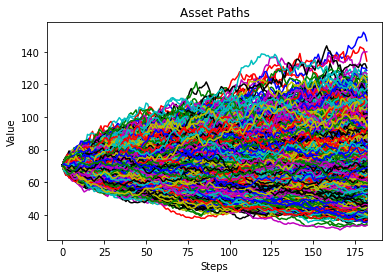

In [54]:
# This is the simulation, analyzing the payoff of 5000 paths given the following:
# Initial price S0 = 70
# Strike price K = 72
# Volatility of the stock price - 0.30
# Risk-free rate r=r(t)= 0.04
# Time Step = 1/365 (daily)
# Time to maturity (in years) T = 0.50 (6 Months)
# Number of Simulated Paths n = 5000
sim_paths = assetPaths(70,0.04,.30,1/365,182,5000)
#Plot the paths
plt.title("Asset Paths")
plt.xlabel("Steps")
plt.ylabel("Value")
temp = 'b'
for x in sim_paths:
    i = np.arange(0,len(x))
    j = np.array(x)
    plt.plot(i,j,temp)
    temp = rotate_color(temp)
    
plt.show()

## Asian Option Payoffs

### Asian Call (Arithmetic Average)

In [55]:
# Compute the average between each Asain Call Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(asianAvgPriceCall(x, 72))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 2.878029556607919
Percentage of payoffs less than the average: 0.7038


### Asian Put (Arithmetic Average)

In [56]:
# Compute the average between each Asain Put Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(asianAvgPricePut(x, 72))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 4.229899920173509
Percentage of payoffs less than the average: 0.6032


### Asian Call (Geometric Average)

In [57]:
# Compute the average between each Asain Call (Geometric?) Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(asianAvgStrikeCall(x))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 3.753150802807321
Percentage of payoffs less than the average: 0.6772


### Asian Put (Geometric Average)

In [58]:
# Compute the average between each Asain Put (Geometric?) Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(asianAvgStrikePut(x))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 3.136079698359927
Percentage of payoffs less than the average: 0.6322


## Looback Options

### Lookback Fixed Strike Call

In [59]:
# Compute the average between each Loopback Fixed Strike Call Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(lookbackFixedCall(x, 72))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 10.89853254366923
Percentage of payoffs less than the average: 0.6028


### Lookback Fixed Strike Put

In [60]:
# Compute the average between each Loopback Fixed Strike Put Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(lookbackFixedPut(x, 72))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 11.994928069463974
Percentage of payoffs less than the average: 0.5538


### Lookback Floating Strike Call

In [61]:
# Compute the average between each Loopback Floating Strike Call Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(lookbackFloatingCall(x))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 11.260128810345755
Percentage of payoffs less than the average: 0.6114


### Lookback Fixed Strike Put

In [62]:
# Compute the average between each Loopback Floating Strike Put Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(lookbackFloatingPut(x))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 11.455283809784817
Percentage of payoffs less than the average: 0.5396


## Chooser Option

In [81]:
# Compute the average between each Chooser Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(chooser(x, 72, 90))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 8.580209908048573
Percentage of payoffs less than the average: 0.5788


## Barrier Options

In [64]:
def rebate():
    return .25

### Down-and-In Call

In [86]:
# Compute the average between each Down-and-In Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(downInCall(x, 63, 72, rebate))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 0.9641170459440723
Percentage of payoffs less than the average: 0.9066


### Down-and-In Put

In [87]:
# Compute the average between each Down-and-In Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(downInPut(x, 63, 72, rebate))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 6.29500385090088
Percentage of payoffs less than the average: 0.6182


### Up-and-In Call

In [92]:
# Compute the average between each Up-and-In Call Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(upInCall(x, 78, 72, rebate))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 5.741776787603369
Percentage of payoffs less than the average: 0.6942


### Up-and-In Put

In [93]:
# Compute the average between each Up-and-In Put Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(upInPut(x, 78, 72, rebate))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 1.304833710839088
Percentage of payoffs less than the average: 0.8564


### Down-and-Out Put

In [94]:
# Compute the average between each Down-and-Out Put Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(downOutPut(x, 63, 72, rebate))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 0.40292547556566005
Percentage of payoffs less than the average: 0.9324


### Down-and-Out Call

In [95]:
# Compute the average between each Down-and-Out Call Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(downOutCall(x, 63, 72, rebate))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 4.9990130214042905
Percentage of payoffs less than the average: 0.7352


### Up-And Out Put

In [96]:
# Compute the average between each Up-and-Out Put Option Payoff
payoffs = []

for x in sim_paths:
    payoffs.append(upOutPut(x, 78, 72, rebate))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 5.393095615627455
Percentage of payoffs less than the average: 0.6734


### Up-And Out Call

In [97]:
# Compute the average between each Up-and-Out Call Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(upOutCall(x, 78, 72, rebate))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 0.22135327974498759
Percentage of payoffs less than the average: 0.3936


## Parisian Options

### Parisian Down-and-In Call

In [73]:
# Compute the average between each Down-and-in Parisian Call Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(parisDownInCall(x,63,72,rebate,5))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 0.25
Percentage of payoffs less than the average: 0.0


### Parisian Down-and-In Put

In [74]:
# Compute the average between each Down-and-in Parisian Put Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(parisDownInPut(x,63,72,rebate,5))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 0.25
Percentage of payoffs less than the average: 0.0


### Parisian Up-and-In Call

In [75]:
# Compute the average between each Up-and-in Parisian Call Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(parisUpInCall(x,78,72,rebate,5))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 5.713130067348354
Percentage of payoffs less than the average: 0.6928


### Parisian Up-and-in Put

In [76]:
# Compute the average between each Up-and-in Parisian Put Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(parisUpInPut(x,78,72,rebate,5))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 6.447929326466543
Percentage of payoffs less than the average: 0.612


### Parisian Down-and-out Call

In [77]:
# Compute the average between each Down-and-out Parisian Call Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(parisDownOutCall(x,63,72,rebate,5))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 5.713130067348354
Percentage of payoffs less than the average: 0.6928


### Parisian Down-and-Out Put

In [78]:
# Compute the average between each Down-and-out Parisian Put Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(parisDownOutPut(x,63,72,rebate,5))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 6.447929326466543
Percentage of payoffs less than the average: 0.612


### Parisian Up-and-out Put

In [79]:
# Compute the average between each Up-and-out Parisian Put Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(parisUpOutPut(x,78,72,rebate,5))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 0.25
Percentage of payoffs less than the average: 0.0


### Parisian Up-and-out Call

In [80]:
# Compute the average between each Up-and-out Parisian Call Option Payoff
payoffs = []
for x in sim_paths:
    payoffs.append(parisUpOutCall(x,78,72,rebate,5))

total = 0
for x in payoffs:
    total += x
    
average = total/len(payoffs)
print(f"Average of the payoffs: {average}")
temp = 0
for x in payoffs:
    if x < average:
        temp += 1
print(f"Percentage of payoffs less than the average: {temp/len(payoffs)}")

Average of the payoffs: 0.25
Percentage of payoffs less than the average: 0.0
